# Image Segmentation with Pre-trained Models

In this tutorial, we show an example using convolutional neural network to perform image segmentation using a pre-trained model. This tutorial assumes familiarity with deep learning concepts. The tutorial is written in Python and uses MXNET framework.

# Prepare the Data

The required model files are hosted at https://bitbucket.org/krishnasumanthm/mxnet_image_segmentation

We first define a download function and download pre-trained model, symbol file and a test image.

Note: The pre-trained model is about 500MB, so first time downloading might take some time.

Other models are available at http://data.mxnet.io/models/

We use a pre-trained fcn-xs model which is based on vgg16 model, with some crop, deconv, element-sum layer added, 

In [1]:
import logging
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, urllib2, time
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
logging.basicConfig(level=logging.DEBUG)
import sys
from PIL import Image
import utils 

In [2]:
sys.path.append('/home/ubuntu/krishna')

In [3]:
#Download function to download required files.
def download(url,filename):
    if not os.path.exists(filename):
        # urllib.urlretrieve(url, filename)
        resp = urllib2.urlopen(url)
        with open(filename, 'wb') as f:
            f.write(resp.read())
        
# Download model file
params_path = 'https://bitbucket.org/krishnasumanthm/mxnet_image_segmentation/src/534d1791c98fc50ee81846ed359f656680439ccc/FCN8s_VGG16-0019.params'
download(params_path, 'FCN8s_VGG16-0019.params')

# Download symbol file
json_path = 'https://bitbucket.org/krishnasumanthm/mxnet_image_segmentation/src/534d1791c98fc50ee81846ed359f656680439ccc/FCN8s_VGG16-symbol.json'
download(json_path, 'FCN8s_VGG16-symbol.json')

# Download image
img_path = 'https://bitbucket.org/krishnasumanthm/mxnet_image_segmentation/src/534d1791c98fc50ee81846ed359f656680439ccc/Bikemore_V2-30.JPG'
download(img_path, 'person_bicycle.jpg')

# Model Preparation
Define argument settings for model. Initialize to use CPU mode.


In [4]:
img = "./person_bicycle.jpg" # Name of input image
seg = img.replace("jpg", "png") # Name of output image is the same with input but in png ext 
model_previx = "FCN8s_VGG16" # Name of model
epoch = 19 # Number of Epoch
ctx = mx.cpu(0) # Use CPU

# Preprocess the data for evaluation
We have to preprocess the data to convert the image to a numpy array. We also define a function within preprocess to get the colormap for visualizing the segmentation mask.

In [5]:
def get_data(img_path):
    # Function to convert input image to np.array
    """get the (1, 3, h, w) np.array data for the img_path"""
    mean = np.array([123.68, 116.779, 103.939])  # (R,G,B)
    img = Image.open(img_path)
    img = np.array(img, dtype=np.float32)
    reshaped_mean = mean.reshape(1, 1, 3)
    img = img - reshaped_mean
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = np.expand_dims(img, axis=0)
    return img

In [6]:
pallete = utils.getpallete(256)

# Evaluate the model.
We load the model and the input image. Get the required metadata of the input image and perform forward propagation and obtain results.

Time taken for forward pass: 0.036 milli sec
Postprocessing results to display output...


DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'


Input Image:


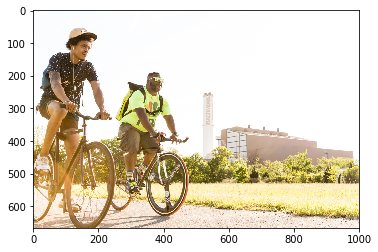

Output Image:


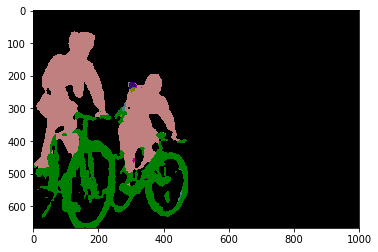

In [7]:
fcnxs, fcnxs_args, fcnxs_auxs = mx.model.load_checkpoint(model_previx, epoch) 
    
# Input images are stored in a 4-D matrix 
fcnxs_args["data"] = mx.nd.array(get_data(img), ctx) 
data_shape = fcnxs_args["data"].shape
label_shape = (1, data_shape[2]*data_shape[3])
fcnxs_args["softmax_label"] = mx.nd.empty(label_shape, ctx)
exector = fcnxs.bind(ctx, fcnxs_args ,args_grad=None, grad_req="null", aux_states=fcnxs_args)

tic = time.time()

utils.get_results(exector,pallete,img,seg)
